# Imports and hyperparameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
import gc

import optuna
import logging

from collections.abc import Callable

from pso_utils import *
from landscapes import *

# Utils

In [2]:
# plotting utils
lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()

# Landscapes plotting

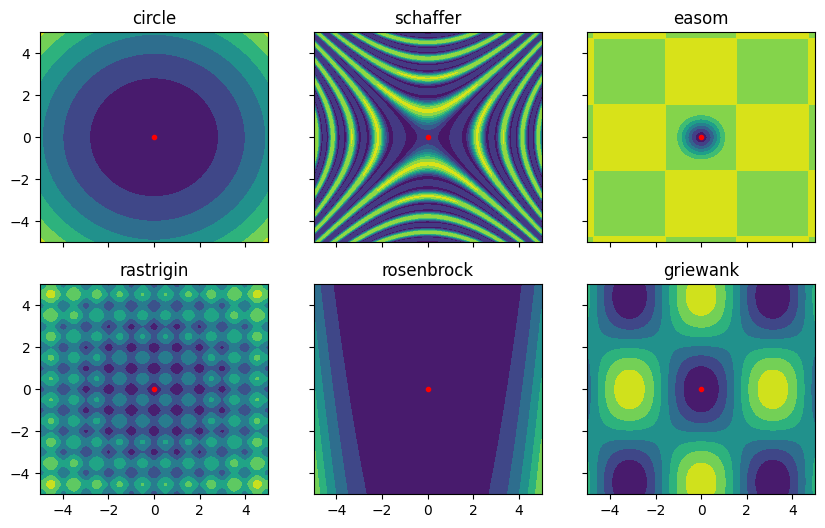

In [3]:
# plot standard landscapes

fig1, axs1 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    # landscape.rotation = rotation
    fit = landscape(pts)
    ax = axs1[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    ax.set_title(landscape.name)

Rotation of 0.4*pi
Minimum = (1, -2)


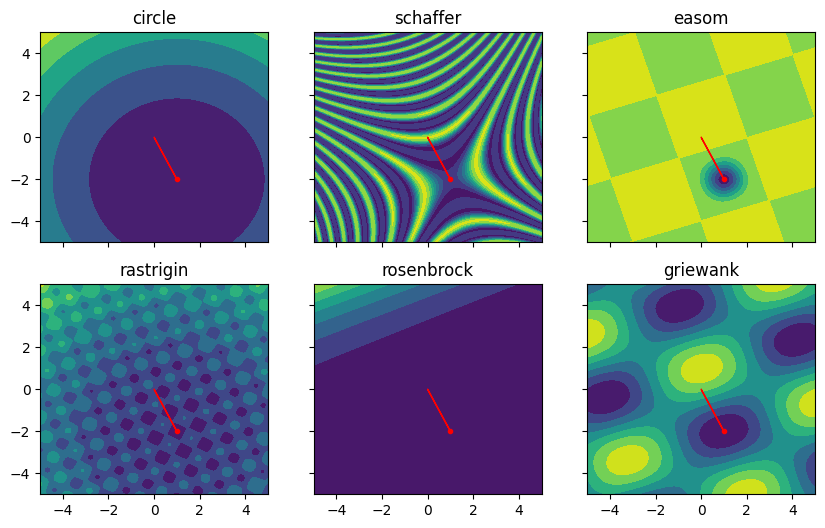

In [4]:
# plot rotated/translated landscapes

angle = 0.4 # pi/4
rotation = generate_rotation_matrix(angle*np.pi)
minimum = np.array([[1, -2]])
print(f'Rotation of {angle}*pi')
print(f'Minimum = ({minimum[0, 0]}, {minimum[0, 1]})')

fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    landscape.rotation = rotation
    landscape.minimum = minimum
    fit = landscape(pts)
    ax = axs2[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    ax.arrow(0, 0, landscape.minimum[0, 0], landscape.minimum[0, 1], color='red')
    ax.set_title(landscape.name)

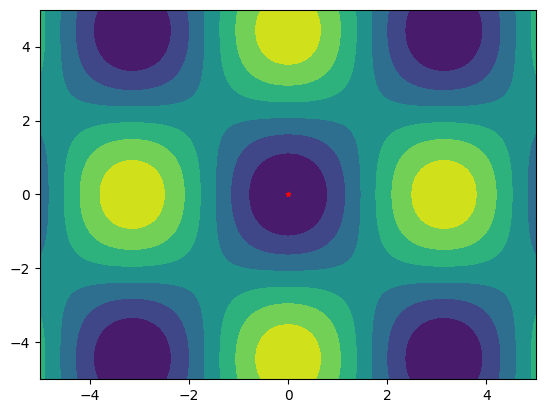

In [5]:
# plot single landscape

fit = griewank(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)

plt.scatter(0, 0, color='red', marker='*', s=9)

# Swarm class

Ideas: ahving velocity update as a function prevents from updating parameter (the internal parameters are always he same, i canno apply decay). This could be solved by implementing a class for the velocity update.

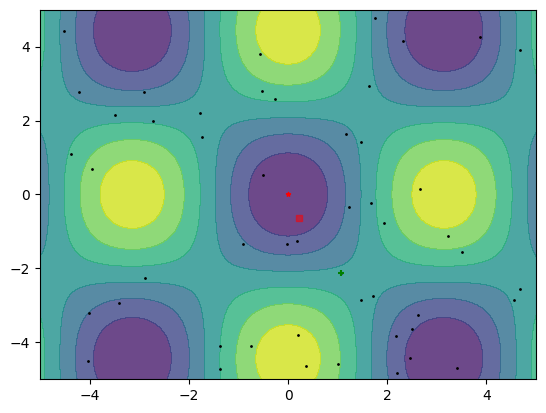

In [6]:
S = SwarmGP(50)
S.default_start(land=RASTRIGIN)

plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.8)

plt.scatter(0, 0, color='red', marker='*', s=9) # -959.64066271
S.plot()

In [7]:
S.generate(100)
S.describe()

best fit value = 0.02330297211643284
best solution = [ 0.00093671 -0.01079936]
center of mass = [ 0.26832426 -0.28268449]
dispersion = 0.8133240421155026


(-5.0, 5.0)

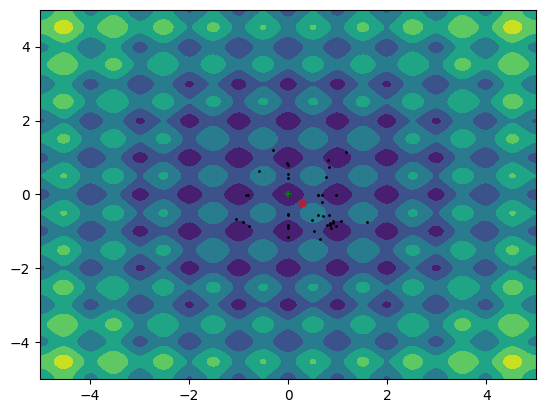

In [8]:
S.generate(100)
fit = RASTRIGIN(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
S.plot()
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Benchmark

We start with just one class of problems (e.g. rastrigin) and try to create a program for this class. Later will be extended to multiple classes. We will generate our solutions only in the [-5, 5] range and move the center in the [-2, 2] of the function. Later we can introduce also scaling of variables and scaling of outputs. But first we only deal with translation.

Paper arrpoach:
- 10 random problems with minima positioned randomly in $[-G, G]^2$ with G=1 or G=2.
- 10 particles, 30 iterations each
- initial coordinates drawn randomly in $[-5, 5]^2$ and velocities set to zero
- for each problem the PSO was run 5 times with initial random configuration
- velocities constrained in [-2, 2]

In [9]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100

best fit value = 2.77662493886055e-07
best solution = [-3.74105712e-05 -1.16234530e-07]
center of mass = [-0.16387097 -0.00241541]
dispersion = 0.992026636105786


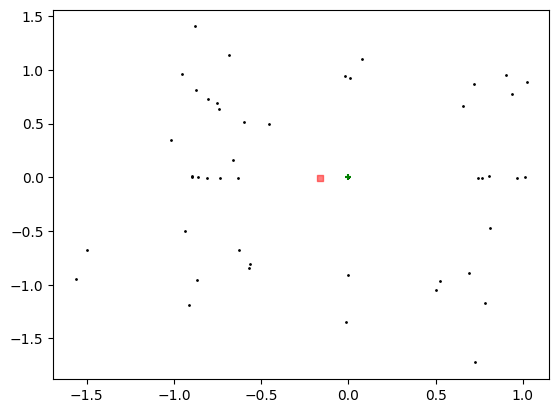

In [10]:
S = SwarmGP(SWARM_SIZE)
S.default_start(land=RASTRIGIN)
S.generate(NUM_ITERATIONS)
S.plot()
S.describe()

In [11]:
# def BaseFitness(soc_factor=1.49, cog_factor=1.49, inertia_weight=0.9, inertia_decay=0.99, inertia_min=0):

#     num_problems = 100
#     t = 5
#     problems_minima = np.zeros((100*t, 2))
#     problems = []

#     for i in range(num_problems):
#         land = random.choice(basic_landscapes)

#         # Create a new instance of the chosen landscape to avoid decoratros mess
#         land = Landscape(land.name, land.func, land.minima.copy())
#         new_minima = np.random.uniform(-2, 2, size=(2,))
#         land.modify_minima(new_minima)

#         problems_minima[i*t: i*t+t] = new_minima

#         for _ in range(t):
#             problems.append(land)

#     raw_results = np.zeros(len(problems))
#     results = np.zeros(num_problems)
#     swarms_record = []
#     best_record = np.zeros((len(problems), 2))

#     for i in range(len(problems)):
#         land = problems[i]
#         S = Swarm(SWARM_SIZE, land.func, soc_factor, cog_factor, inertia_weight, inertia_decay, inertia_min)
#         S.generate(NUM_ITERATIONS)
#         best_record[i] = S.global_best
#         swarms_record.append(S)

#     # Clear problems to release memory: OLD
#     # del problems
#     # gc.collect()

#     # Process results
#     raw_results = distance(best_record, problems_minima)
#     results = raw_results.reshape((-1, 5)).mean(axis=1)

#     return results


In [12]:
# results = BaseFitness(soc_factor=1.49, cog_factor=1.49, inertia_weight=0.9, inertia_decay=0.01, inertia_min=0)

## NEW FITNESS

In [13]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100

In [14]:
def generate_problems(NUM_PROBLEMS):
    problems = []
    new_minima = np.random.uniform(-2, 2, size=(NUM_PROBLEMS, 2))
    angles = np.random.uniform(0, 2, (NUM_PROBLEMS,))
    for i in range(NUM_PROBLEMS):
        name = random.choice(landscapes_names)
        land = Landscape(name, landscapes_dict[name])
        land.minimum = new_minima[i]
        angle = angles[i]
        land.rotation = generate_rotation_matrix(angle*np.pi)
        problems.append(land)
    return problems

In [15]:
problems = generate_problems(NUM_PROBLEMS)

S = SwarmGP(SWARM_SIZE)

In [16]:
def PSOResults(swarm: SwarmGP, problems):
    """Returns an array of the best result obtained by the PSO on the problems contained in the problems list"""

    n_problems = len(problems)
    
    results = np.zeros(n_problems)
    swarms_best = np.zeros((len(problems), 2))
    problems_minima = np.zeros((n_problems, 2))

    for i in range(n_problems):
        problems_minima = problems[i].minimum
        swarm.default_start(land=problems[i])
        swarm.generate(NUM_ITERATIONS)
        swarms_best[i] = swarm.global_best

    # Process results
    results = distance(swarms_best, problems_minima)

    return results

In [17]:
results = PSOResults(S, problems)

In [18]:
np.std(results), np.mean(results), np.median(results)

(1.3993737307056804, 2.2733594841715394, 2.1888488913974005)

In [19]:
float(np.median(results) + np.std(results))

3.588222622103081

# Hyperparameter optimization

In [20]:
def original_update_dec(soc_factor, cog_factor, inertia_weight):

    def new_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion):
        return original_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion, soc_factor=soc_factor, cog_factor=cog_factor, inertia_weight=inertia_weight)
    return new_update

In [21]:
# def objective(trial):
#     soc_factor = trial.suggest_float('soc_factor', 0, 5)
#     cog_factor = trial.suggest_float('cog_factor', 0, 5)
#     inertia_weight = trial.suggest_float('inertia_weight', 0, 5)
#     # inertia_decay = trial.suggest_float('inertia_decay', 0, 1)
#     # inertia_min = trial.suggest_float('inertia_min', 0, 5)
#     vel_update = original_update_dec(soc_factor, cog_factor, inertia_weight)

#     # results = GPFitness(soc_factor, cog_factor, inertia_weight, inertia_decay, inertia_min)
#     results = BaseFitness(soc_factor, cog_factor, inertia_weight)

#     return float(np.median(results) + np.std(results))

In [22]:
# def GPObjective(trial):
#     soc_factor = trial.suggest_float('soc_factor', 0, 5)
#     cog_factor = trial.suggest_float('cog_factor', 0, 5)
#     inertia_weight = trial.suggest_float('inertia_weight', 0, 5)
#     vel_update = original_update_dec(soc_factor, cog_factor, inertia_weight)
#     swarm = SwarmGP(SWARM_SIZE, vel_update=vel_update)

#     results = PSOResults(swarm, generate_problems(NUM_PROBLEMS))

#     return float(np.median(results) + np.std(results))

In [23]:
# # optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
# study_name = "optimization_folder/modular_version1"  # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)
# study.optimize(GPObjective, n_trials=200, )

In [24]:
# study.best_params

In [25]:
# [p.name for p in problems]

In [26]:
# study.trials[0].params

In [27]:
# soc = []
# cog = []
# inertia = []
# score = []
# for t in study.trials:
#     if t.value < 100:
#         params = t.params
#         soc.append(params['soc_factor'])
#         cog.append(params['cog_factor'])
#         inertia.append(params['inertia_weight'])
#         score.append(1/t.value)

In [28]:
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D

# # Creating data
# x = np.array(soc)
# y = np.array(cog)
# X, Y = np.meshgrid(x, y)
# Z = np.sin(np.sqrt(X**2 + Y**2))

# # Creating a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plotting the basic 3D surface
# # ax.plot_surface(X, Y, Z, cmap='viridis')
# ax.scatter(soc, cog, inertia, c=score)


# # Customizing the plot
# ax.set_xlabel('soc')
# ax.set_ylabel('cog')
# ax.set_zlabel('inertia')
# ax.set_title('Basic 3D Surface Plot')
# # ax.view_init(-170, 10)

# # Displaying the plot
# plt.show()

# GP

In [29]:
import operator
import math
import random

import numpy

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from pso_utils import *
from landscapes import *

In [ ]:
def get_ones(_):
    return np.ones((SWARM_SIZE, 2))

def get_pi(_):
    return get_ones(None) * np.pi

In [139]:
pset = gp.PrimitiveSet("MAIN", 6)
# basic
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.negative, 1)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)

# # random
# pset.addPrimitive(gen_random, 1)

# others
# pset.addPrimitive(np.cos, 1)
# pset.addPrimitive(np.sin, 1)
# pset.addPrimitive(compute_magnitude, 1)
# pset.addPrimitive(distance, 2)


# PRIMITIVES
pset.addTerminal(np.pi)
pset.addTerminal(1)
# ephemeral constants
pset.addEphemeralConstant("rand101", partial(random.uniform, 0, 5))
pset.addEphemeralConstant("rand102", partial(random.uniform, 0, 5))
pset.addEphemeralConstant("rand103", partial(random.uniform, 0, 5))


# variables
pset.renameArguments(ARG0="swarm")
pset.renameArguments(ARG1="vel")
pset.renameArguments(ARG2='gbest')
pset.renameArguments(ARG3='pbest')
pset.renameArguments(ARG4='center')
pset.renameArguments(ARG5='dispersion')

In [140]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=5, max_=12)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [141]:
problems_gp = generate_problems(NUM_PROBLEMS)

In [142]:
def func_dec(func):
    def new_func(swarm, velocity, global_best, personal_best, center_mass, dispersion):
        value = func(swarm, velocity, global_best, personal_best, center_mass, dispersion)
        if not isinstance(value, np.ndarray):
            return np.zeros((SWARM_SIZE, 2))
        else:
            return value
    return new_func

In [143]:
def GPFitness(individual):
    problems = generate_problems(NUM_PROBLEMS)
    func = toolbox.compile(expr=individual)
    func = func_dec(func)
    vel_update = func
    S = SwarmGP(SWARM_SIZE, vel_update=vel_update)
    results = PSOResults(S, problems)
    value = float(np.median(results) + np.std(results))
    print(f'value = {value} -> ind = {individual}')
    return value,

In [144]:
toolbox.register("evaluate", GPFitness)
toolbox.register("select", tools.selTournament, tournsize=3) # selction
toolbox.register("mate", gp.cxOnePoint) # crossover
toolbox.register("expr_mut", gp.genFull, min_=0, max_=10)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [147]:
def main():
    random.seed(318)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, ngen=20, stats=mstats,
                                   halloffame=hof, verbose=False)
    # print log
    return pop, log, hof

In [148]:
pop, log, hof = main()

value = 82.54643796488664 -> ind = multiply(multiply(negative(subtract(multiply(1.879534846460591, negative(negative(vel))), multiply(1, 1))), multiply(add(multiply(dispersion, vel), negative(pbest)), negative(add(vel, dispersion)))), add(multiply(add(negative(subtract(vel, center)), add(center, 0.3404694188102153)), add(multiply(3.141592653589793, pbest), add(vel, add(center, 1.3718674890667497)))), negative(add(subtract(center, negative(4.5546037709544285)), subtract(multiply(3.1733298303216957, swarm), subtract(dispersion, 1))))))
value = 157.34767097800687 -> ind = multiply(add(negative(multiply(add(swarm, dispersion), multiply(dispersion, negative(center)))), add(negative(subtract(3.141592653589793, pbest)), add(multiply(dispersion, vel), multiply(3.141592653589793, 1.2154254509882612)))), negative(negative(negative(negative(2.6646554598966397)))))
value = 61.09605716585241 -> ind = multiply(multiply(subtract(add(add(multiply(add(subtract(multiply(negative(negative(1.2061382054913

In [153]:
pop

[[<deap.gp.Primitive at 0x1bc6bd4ce00>,

In [154]:
str(hof[0])

'subtract(1.1229994919240687, multiply(negative(swarm), add(negative(multiply(4.411626377118953, 3.141592653589793)), dispersion)))'

# string representation

In [149]:
operations = [
    'negative',
    'subtract',
    'multiply',
    'negate',
    'add',
]

In [ ]:
expr = 'multiply(multiply(subtract(add(add(multiply(add(subtract(multiply(negative(negative(1.2061382054913272)), multiply(multiply(3.141592653589793, 2.792975412630669), negative(swarm))), subtract(subtract(multiply(1.3535018756499855, swarm), add(swarm, 1)), add(negative(1), multiply(center, gbest)))), negative(add(subtract(negative(dispersion), add(3.141592653589793, gbest)), negative(add(3.420888396619452, gbest))))), negative(add(multiply(multiply(add(4.546230784165469, 1), subtract(1.2863324133037861, dispersion)), add(negative(swarm), subtract(3.141592653589793, 1))), subtract(multiply(subtract(1, gbest), negative(3.141592653589793)), multiply(negative(center), subtract(swarm, 3.141592653589793)))))), add(multiply(add(add(subtract(multiply(3.141592653589793, 4.867982913485721), negative(1)), subtract(negative(3.141592653589793), negative(pbest))), negative(multiply(subtract(dispersion, 3.141592653589793), add(swarm, pbest)))), negative(negative(subtract(add(gbest, 3.865779421527601), negative(dispersion))))), subtract(add(multiply(negative(subtract(0.9117810978010121, 3.141592653589793)), subtract(negative(swarm), add(3.141592653589793, 1))), add(subtract(add(center, 3.141592653589793), add(gbest, pbest)), subtract(negative(3.141592653589793), add(3.141592653589793, gbest)))), negative(subtract(multiply(multiply(3.141592653589793, dispersion), multiply(2.1480037908235285, 3.898786075691051)), add(negative(vel), add(0.6306849011410331, 1))))))), add(add(multiply(multiply(subtract(subtract(subtract(2.9594382282107046, center), subtract(3.141592653589793, 1)), subtract(negative(2.2875709305324436), negative(1.960091850902674))), multiply(multiply(add(vel, pbest), add(4.168135108081047, swarm)), negative(add(0.8440895212388716, dispersion)))), add(subtract(multiply(multiply(dispersion, 3.649539204718388), multiply(1, 3.141592653589793)), subtract(subtract(3.141592653589793, pbest), add(1, swarm))), multiply(negative(multiply(vel, dispersion)), multiply(subtract(vel, gbest), subtract(dispersion, 3.141592653589793))))), add(negative(add(subtract(add(pbest, pbest), negative(3.141592653589793)), negative(subtract(3.8726259990413188, vel)))), add(add(subtract(add(4.891222005503547, 3.1188397983779885), negative(center)), subtract(add(pbest, 1), multiply(1.5875930653304997, center))), negative(subtract(multiply(3.141592653589793, center), multiply(4.96315112781103, 1)))))), negative(negative(add(add(negative(add(1, center)), negative(subtract(vel, pbest))), subtract(multiply(multiply(4.947735318630717, 3.81013802537399), subtract(1, 1)), multiply(negative(1), add(1.9886957956258815, 3.141592653589793)))))))), multiply(multiply(add(negative(negative(multiply(multiply(add(gbest, pbest), subtract(gbest, 1)), multiply(add(dispersion, center), subtract(gbest, 1))))), subtract(negative(negative(multiply(multiply(swarm, vel), add(swarm, swarm)))), subtract(add(multiply(negative(0.3488706273004333), add(pbest, pbest)), negative(multiply(1, pbest))), multiply(subtract(negative(1.6755814500064825), subtract(dispersion, center)), multiply(add(1, gbest), subtract(pbest, swarm)))))), add(multiply(multiply(subtract(multiply(subtract(1, swarm), add(4.697687523607856, center)), add(negative(center), subtract(dispersion, 1.1012160510907716))), negative(add(negative(0.7284371899355035), negative(2.449513409030617)))), subtract(negative(subtract(negative(1), add(dispersion, pbest))), subtract(add(add(swarm, center), add(swarm, 1.547079513370106)), add(multiply(vel, center), multiply(swarm, 3.141592653589793))))), add(subtract(negative(subtract(subtract(swarm, gbest), add(3.7044989180215304, 1))), add(subtract(subtract(3.141592653589793, swarm), subtract(swarm, 3.2571538668016933)), subtract(negative(gbest), negative(1)))), add(subtract(add(subtract(gbest, 3.141592653589793), multiply(4.746867677774674, 4.4124716094441725)), subtract(subtract(gbest, 1.9275867122325474), add(2.0590176411432184, gbest))), multiply(negative(multiply(3.141592653589793, swarm)), subtract(add(gbest, 1), multiply(dispersion, 0.5784340786940689))))))), multiply(negative(add(add(multiply(multiply(add(4.5687225958050774, swarm), subtract(vel, 2.5948628143618064)), add(multiply(gbest, 3.1039950298291936), multiply(1, 1.5963408883942116))), add(add(negative(3.141592653589793), add(dispersion, swarm)), add(subtract(vel, gbest), add(center, gbest)))), negative(add(multiply(multiply(pbest, gbest), negative(4.691390212366899)), add(add(3.570690305836232, 3.9361621886539306), add(pbest, center)))))), negative(negative(add(add(subtract(add(4.394315002721117, center), multiply(center, gbest)), multiply(add(center, 1.122853261679408), subtract(swarm, center))), subtract(add(multiply(vel, 1), multiply(gbest, swarm)), add(multiply(gbest, swarm), subtract(pbest, dispersion))))))))), add(negative(add(multiply(negative(negative(add(multiply(negative(center), add(4.922313189646266, 1)), subtract(subtract(swarm, 1.9922083408502456), add(1.5378556367200051, 4.662107875563425))))), negative(multiply(multiply(add(subtract(dispersion, 3.141592653589793), multiply(center, 3.141592653589793)), multiply(multiply(3.0413876277008702, swarm), negative(1))), add(negative(negative(pbest)), multiply(negative(vel), multiply(3.141592653589793, 3.141592653589793)))))), subtract(negative(subtract(negative(negative(negative(1))), negative(multiply(negative(2.1097322707409925), multiply(swarm, 4.6001442712698974))))), subtract(multiply(subtract(multiply(add(center, 4.99908610800761), add(0.3224860993788303, dispersion)), subtract(multiply(0.2701579732855519, pbest), multiply(2.575995404941348, 1))), negative(multiply(negative(3.9857629551265603), multiply(1, 0.6044039500847459)))), subtract(multiply(multiply(negative(pbest), multiply(4.530453391139108, vel)), subtract(subtract(pbest, 3.7945203139076753), subtract(1.3275245123142054, dispersion))), subtract(negative(add(dispersion, 1)), subtract(multiply(3.141592653589793, 4.483364438848042), subtract(gbest, center)))))))), multiply(add(add(add(add(subtract(subtract(subtract(2.7514070932985275, swarm), subtract(vel, 1)), subtract(multiply(swarm, swarm), multiply(gbest, gbest))), subtract(multiply(add(3.141592653589793, gbest), subtract(pbest, 0.45488804463832466)), negative(subtract(3.141592653589793, 1.0897868079565776)))), negative(multiply(subtract(multiply(swarm, 1), subtract(gbest, center)), subtract(multiply(dispersion, 0.8271796319794023), negative(dispersion))))), negative(add(negative(add(add(dispersion, 0.3973684845530673), add(1, 3.960434018581536))), subtract(subtract(subtract(center, swarm), negative(4.04865319917576)), subtract(add(vel, swarm), negative(center)))))), add(negative(subtract(add(add(add(3.141592653589793, gbest), add(swarm, 2.4405970173180584)), subtract(negative(gbest), subtract(dispersion, 3.141592653589793))), add(subtract(subtract(pbest, gbest), multiply(center, center)), negative(subtract(0.9258007995010331, 3.434582435432512))))), subtract(multiply(add(multiply(subtract(pbest, center), multiply(4.0754461106211455, pbest)), add(negative(swarm), subtract(2.4396754472515445, dispersion))), multiply(add(negative(pbest), multiply(swarm, center)), negative(multiply(pbest, 1.5273982709093143)))), multiply(negative(multiply(multiply(1.2639232818488084, 1.2760818355068715), negative(4.669112760737989))), add(add(multiply(pbest, dispersion), multiply(center, dispersion)), negative(subtract(dispersion, center))))))), negative(subtract(subtract(add(subtract(add(negative(1), negative(gbest)), negative(negative(vel))), negative(multiply(multiply(1, swarm), multiply(1, swarm)))), subtract(add(multiply(subtract(dispersion, 1.479284817125387), add(3.6738471008987075, 0.8640386709067627)), subtract(subtract(dispersion, 0.35136573225063195), subtract(dispersion, vel))), multiply(negative(negative(3.7973830938704767)), multiply(subtract(vel, gbest), add(1, 1))))), negative(subtract(add(add(negative(3.7664409359798663), negative(vel)), multiply(subtract(pbest, 3.5408966730252778), subtract(4.61764275214489, 2.8279558055960843))), subtract(subtract(subtract(0.4202708515333098, center), multiply(3.141592653589793, dispersion)), subtract(add(vel, gbest), multiply(2.1110606004821704, gbest)))))))))), negative(negative(add(negative(add(subtract(multiply(multiply(multiply(negative(vel), negative(pbest)), negative(subtract(center, center))), subtract(subtract(add(1.3468062365494482, dispersion), add(vel, dispersion)), subtract(add(swarm, gbest), add(gbest, dispersion)))), multiply(subtract(subtract(negative(dispersion), negative(swarm)), add(multiply(vel, swarm), add(dispersion, vel))), multiply(subtract(subtract(1, center), add(1, vel)), negative(subtract(swarm, 4.756204659805515))))), add(add(negative(add(subtract(1.6856633437357793, pbest), subtract(pbest, pbest))), negative(negative(add(pbest, swarm)))), negative(add(add(subtract(pbest, pbest), add(dispersion, vel)), multiply(multiply(3.474463246094275, swarm), negative(1))))))), negative(negative(negative(multiply(negative(subtract(multiply(dispersion, 1.80219060315008), multiply(pbest, pbest))), multiply(negative(negative(gbest)), add(negative(3.141592653589793), add(4.648141601845731, gbest)))))))))))'

In [ ]:
'subtract(subtract(negative(multiply(subtract(1.2375081118745572, center), negative(add(subtract(dispersion, 0.5142041335443548), 3.719699770076712)))), negative(negative(subtract(1.1229994919240687 + 1 + gbest -vel), 3.141592653589793)))), -swarm * [ - 3.2178005605337567 * 3.141592653589793  - dispersion + center]))))'